# STROKE PREDICTION WITH DECISION TREE

# 1. Prepare Problem

## 1.1 Setup environment

Run the code block below

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
import seaborn
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, CondensedNearestNeighbour, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn import tree
from pickle import dump, load
from mlxtend.plotting import plot_decision_regions

pd.set_option('display.width', 1000)
pd.set_option('precision', 3)

# Box plots
def my_boxplot(data, labels, xlabel, ylabel, title):
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    pyplot.boxplot(data)
    ax.set_xticklabels(labels)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.title(title)
    pyplot.savefig(xlabel + ".png")
    pyplot.show()


def my_lineplot(x, y1, y2, label1, label2, xlabel, ylabel, title):
    line1 = pyplot.plot(x, y1, '-o', label=label1)
    line2 = pyplot.plot(x, y2, '-o', label=label2)
    pyplot.legend()
    pyplot.ylabel(ylabel)
    pyplot.xlabel(xlabel)
    pyplot.savefig(title + ".png")
    pyplot.show()


## 1.2 Load dataset

Run the code block below

In [2]:
filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

# 2. Summarize Data

## 2.1) Descriptive statistics

### View few first rows

In [212]:
data.head(10)

gender   age  hypertension  heart_disease ever_married      work_type Residence_type  avg_glucose_level   bmi   smoking_status  stroke
id                                                                                                                                           
9046     Male  67.0             0              1          Yes        Private          Urban             228.69  36.6  formerly smoked       1
51676  Female  61.0             0              0          Yes  Self-employed          Rural             202.21   NaN     never smoked       1
31112    Male  80.0             0              1          Yes        Private          Rural             105.92  32.5     never smoked       1
60182  Female  49.0             0              0          Yes        Private          Urban             171.23  34.4           smokes       1
1665   Female  79.0             1              0          Yes  Self-employed          Rural             174.12  24.0     never smoked       1
56669    Male  81.0             0              0          Yes        Private          Urban             186.21  29.0  formerly smoked       1
53882    Male  74.0             1              1          Yes        Private          Rural              70.09  27.4     never smoked       1
10434  Female  69.0             0              0           No        Private          Urban              94.39  22.8     never smoked       1
27419  Female  59.0             0              0          Yes        Private          Rural              76.15   NaN          Unknown       1
60491  Female  78.0             0              0          Yes        Private          Urban              58.57  24.2          Unknown       1

### Dimensions of data

In [3]:
data.shape

(5110, 11)

### Data type of each attribute

In [4]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Statistical summary

In [5]:
data.describe()

age  hypertension  heart_disease  avg_glucose_level       bmi    stroke
count  5110.000      5110.000       5110.000           5110.000  4909.000  5110.000
mean     43.227         0.097          0.054            106.148    28.893     0.049
std      22.613         0.297          0.226             45.284     7.854     0.215
min       0.080         0.000          0.000             55.120    10.300     0.000
25%      25.000         0.000          0.000             77.245    23.500     0.000
50%      45.000         0.000          0.000             91.885    28.100     0.000
75%      61.000         0.000          0.000            114.090    33.100     0.000
max      82.000         1.000          1.000            271.740    97.600     1.000

We pay attention to the `bmi` attribute which has 4909 observations summarized whereas other attributes have 5110 observations. This imply `bmi` might have missing values.

### Class distribution

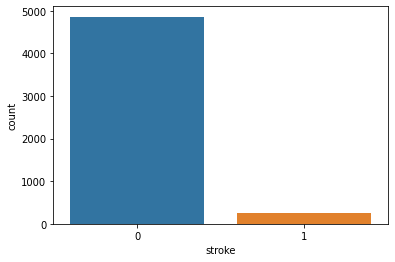

In [3]:
seaborn.countplot(x='stroke', data=data)
pyplot.savefig("class_distribution.png")
pyplot.show()

In [11]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Our dataset is severely imbalanced: $\frac{\text{#stroke}}{\text{#not stroke}} = \frac{1}{20}$

### Identify Columns That Have Very Few Values

In [7]:
n_uniques = data.nunique()
print("Number of unique values in each columns")
print("{:<20}{:>8}{:>12}\t {}".format("Column", "n_unique", "Percentage", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in data.columns:
    percentage = n_uniques[col] / data.shape[0] * 100
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (data[col].unique() if percentage < 1 else ""))

Number of unique values in each columns
Column              n_unique  Percentage	 Unique values
-----------------------------------------------------------------------------------------
gender                     2         0.0%	 ['Male' 'Female']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3978        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke                     2         0.0%	 [1 0]


Luckily, we don't have any single-value columns.

Downhere, we'll mark columns which have number of unique values less than 1% of total number of observations as categorical.

### Distinguish Numerical and Categorical Features

Run the code block below

In [3]:
# Remove outlier associated with `age` (only 1 outlier)
data = data[data['gender'] != "Other"]

# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
for col in features:
    percentage = n_uniques[col]/data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("Categorical:", categorical_ix)
print("Numerical:", numerical_ix)

Categorical: ['smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']
Numerical: ['age', 'avg_glucose_level', 'bmi']


## 2.2) Data visualizations

### Univariate Plots

#### Histograms

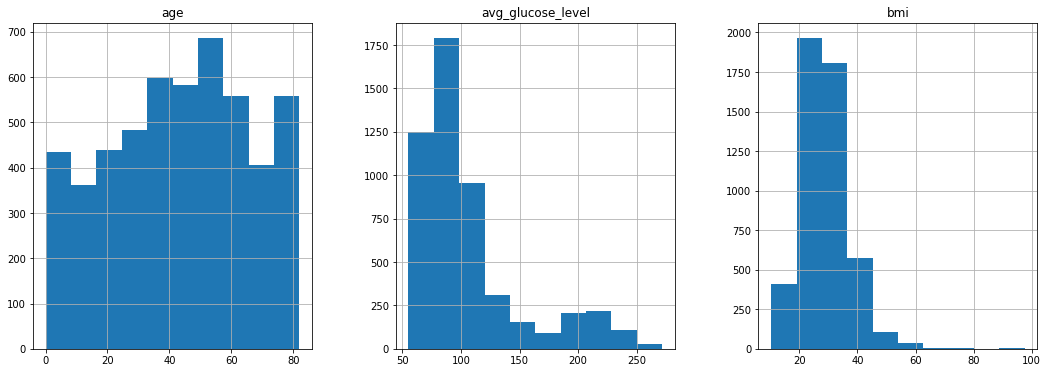

In [17]:
data[numerical_ix].hist(figsize=(18, 6), layout=(1, 3))
pyplot.show()

#### Density Plots

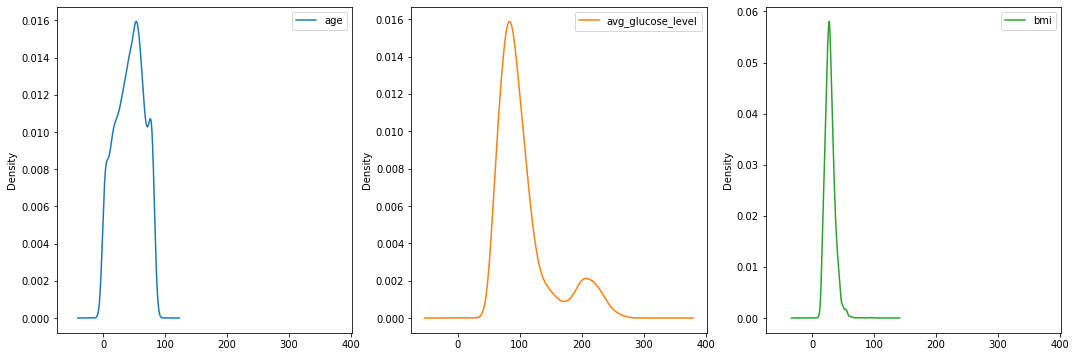

In [20]:
data[numerical_ix].plot(kind='density', subplots=True, layout=(1,3), figsize=(18, 6))
pyplot.show()

#### Box and Whisker Plots

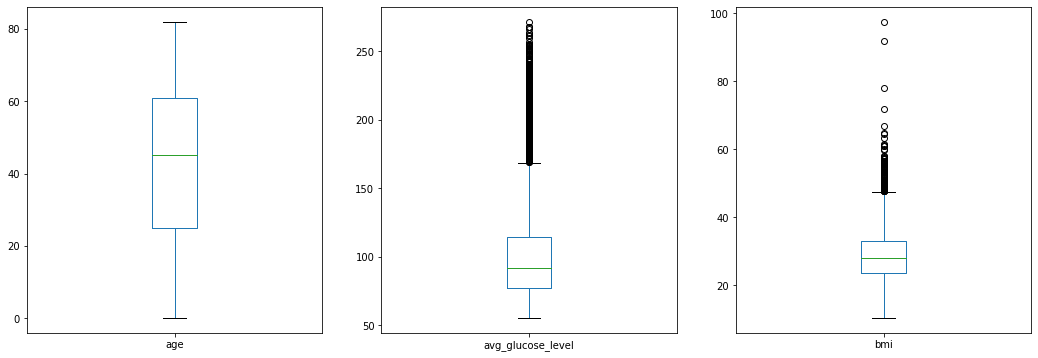

In [5]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.savefig("boxplot_before.png")
pyplot.show()

#### Bar Plots

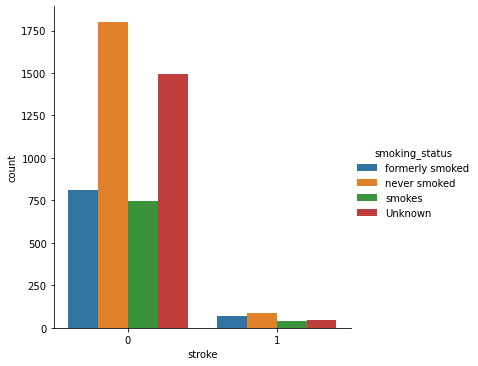

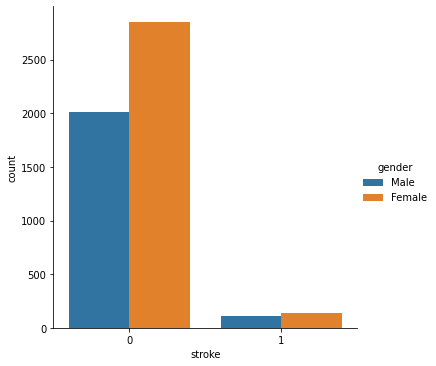

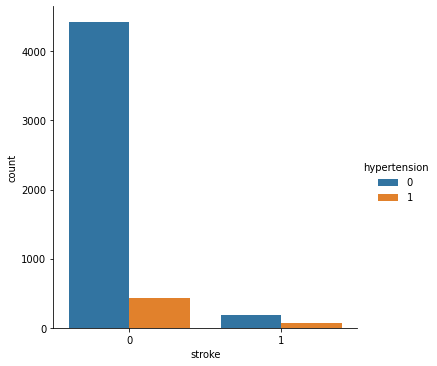

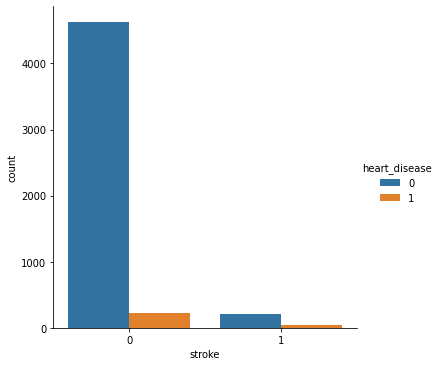

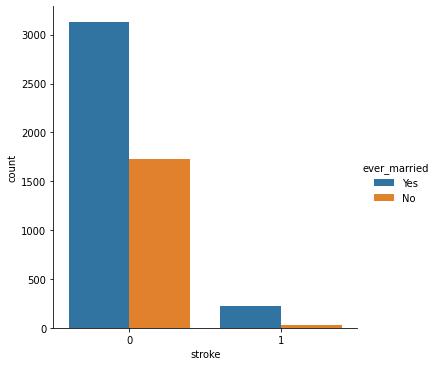

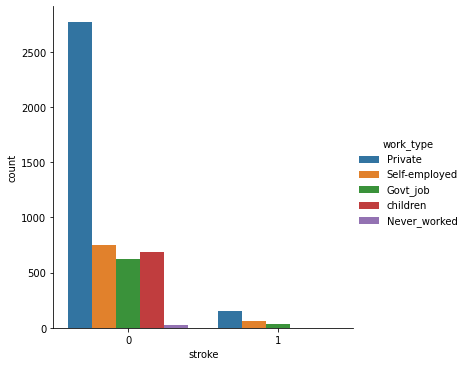

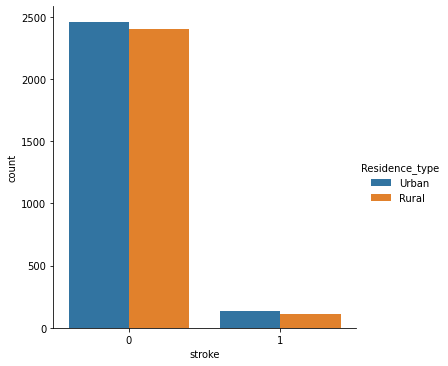

In [20]:
i = 0
# fig, ax = pyplot.subplots(3, 3, figsize=(21, 21))
for col in categorical_ix:
    # ax[i//3][i % 3]
    seaborn.catplot(x='stroke', kind='count', data=data, hue=col)
    # pyplot.title(col + ' distribution')
    # i += 1

# pyplot.show()

### Multivariate Plots

#### Correlation Matrix Plot

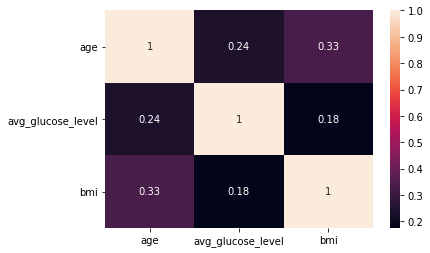

In [69]:
correlations = data[numerical_ix].corr(method='pearson')
seaborn.heatmap(correlations, annot=True)
pyplot.show()

#### Pair Plots

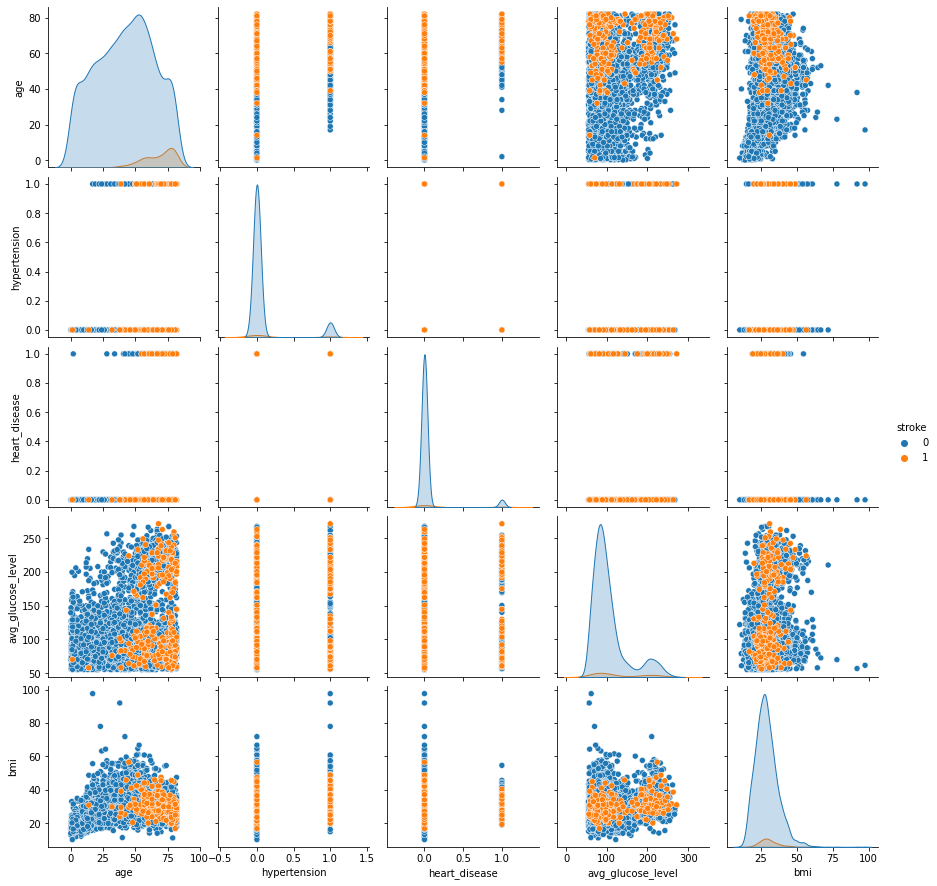

In [6]:
seaborn.pairplot(data.sort_values('stroke'), hue='stroke')
pyplot.savefig("pairplot.png")
pyplot.show()

# 3. Prepare Data

## 3.1) Data Cleaning

### Check label noise
Run the code block below

In [7]:
dups = data[features].duplicated()
data[dups].shape

(0, 11)

Luckily, there's no sign of label noise.

### Look for outliers on numerical features

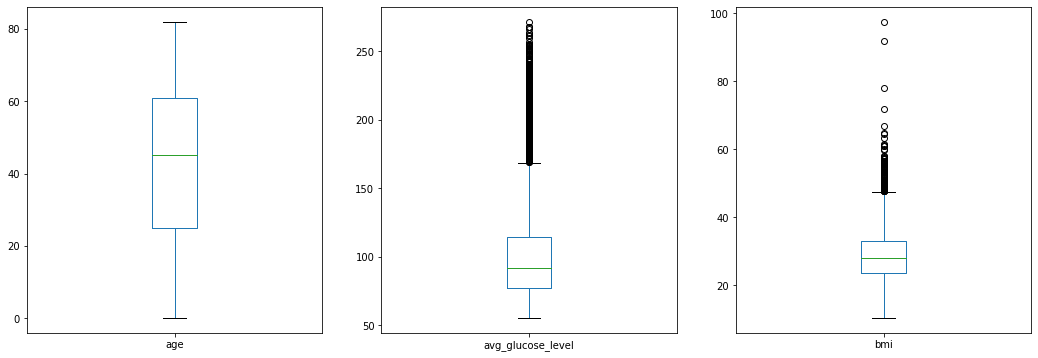

age  avg_glucose_level       bmi
count  5109.000           5109.000  4908.000
mean     43.230            106.140    28.895
std      22.614             45.285     7.854
min       0.080             55.120    10.300
25%      25.000             77.240    23.500
50%      45.000             91.880    28.100
75%      61.000            114.090    33.100
max      82.000            271.740    97.600

In [5]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.show()

data[numerical_ix].describe()

By looking at the table, box plot and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70


#### Option 1: Outlier Detection By Standard Deviation Method

From histogram, we assume *bmi* have near-Gaussian distribution. So we can apply Standard Deviation method in defining outliers.

Factor 4 of standard deviation from mean seems to be a reasonable boundary with *bmi* values.

If you want to use this method, run the code block below

In [ ]:
outlier_strategy = 'Standard_Deviation_Outlier_Detection'
bmi_mean, bmi_std = data["bmi"].mean(), data["bmi"].std()
factor = 4
cut_off = bmi_std * factor
bmi_upper = bmi_mean + cut_off
age_lower = 1

#### Option 2: Outlier Detection By Quantile Range

Factor 4 of IQR from quantile 75th seems to be a reasonable boundary with *bmi* values.

If you want to use this method, run the code block below


In [5]:
outlier_strategy = 'Quantile_Range_Outlier_Detection'
q25, q75 = data['bmi'].quantile(0.25), data['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
age_lower = 1

#### Detect and view outliers

Run the code block below

Quantile_Range_Outlier_Detection
UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


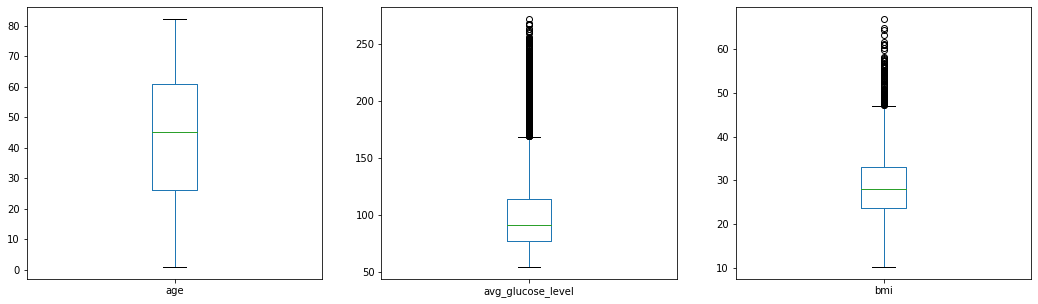

> THESE ARE OUTLIERS:


gender    age  hypertension  heart_disease ever_married work_type Residence_type  avg_glucose_level   bmi smoking_status  stroke
id                                                                                                                                     
7559   Female   0.64             0              0           No  children          Urban              83.82  24.9        Unknown       0
22706  Female   0.88             0              0           No  children          Rural              88.11  15.5        Unknown       0
545      Male  42.00             0              0          Yes   Private          Rural             210.48  71.9   never smoked       0
61511  Female   0.32             0              0           No  children          Rural              73.71  16.2        Unknown       0
41097  Female  23.00             1              0           No   Private          Urban              70.03  78.0         smokes       0
54747    Male   0.88             0              0           No  children          Rural             157.57  19.2        Unknown       0
53279    Male   0.24             0              0           No  children          Rural             118.87  16.3        Unknown       0
66772  Female   0.32             0              0           No  children          Rural              55.86  16.0        Unknown       0
68908  Female   0.72             0              0           No  children          Urban              66.36  23.0        Unknown       0
30084    Male   0.80             0              0           No  children          Rural              98.67  17.5        Unknown       0
40544    Male   0.40             0              0           No  children          Urban             109.56  14.3        Unknown       0
47350  Female   0.08             0              0           No  children          Urban             139.67  14.1        Unknown       0
53126  Female   0.64             0              0           No  children          Urban              62.27  17.3        Unknown       0
6596     Male   0.56             0              0           No  children          Rural             111.77  21.1        Unknown       0
42500    Male   0.24             0              0           No  children          Rural             146.97  18.5        Unknown       0
67099    Male   0.56             0              0           No  children          Rural              57.02  20.7        Unknown       0
34261    Male   0.64             0              0           No  children          Rural              86.74  16.2        Unknown       0
38920    Male   0.48             0              0           No  children          Urban              73.02   NaN        Unknown       0
56420    Male  17.00             1              0           No   Private          Rural              61.67  97.6        Unknown       0
1275     Male   0.88             0              0           No  children          Urban             112.19  18.9        Unknown       0
20257    Male   0.88             0              0           No  children          Urban              90.62  22.4        Unknown       0
48406    Male   0.88             0              0           No  children          Urban              85.38  23.4        Unknown       0
68382    Male   0.32             0              0           No  children          Urban             127.78  20.8        Unknown       0
61836  Female   0.80             0              0           No  children          Urban             106.59  15.5        Unknown       0
760      Male   0.80             0              0           No  children          Urban              75.22  33.1        Unknown       0
42938    Male   0.64             0              0           No  children          Urban              60.40  17.3        Unknown       0
64974    Male   0.24             0              0           No  children          Urban              58.35  18.6        Unknown       0
14877    Male   0.56             0              0           No 

Quantile_Range_Outlier_Detection
UPPER BOUND FOR BMI IS NOW: 71.5
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 47


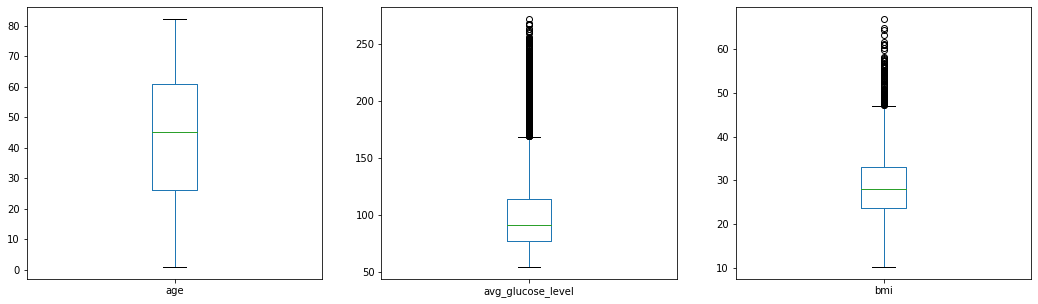

> THESE ARE OUTLIERS:


gender    age  hypertension  heart_disease ever_married work_type Residence_type  avg_glucose_level   bmi smoking_status  stroke
id                                                                                                                                     
7559   Female   0.64             0              0           No  children          Urban              83.82  24.9        Unknown       0
22706  Female   0.88             0              0           No  children          Rural              88.11  15.5        Unknown       0
545      Male  42.00             0              0          Yes   Private          Rural             210.48  71.9   never smoked       0
61511  Female   0.32             0              0           No  children          Rural              73.71  16.2        Unknown       0
41097  Female  23.00             1              0           No   Private          Urban              70.03  78.0         smokes       0
54747    Male   0.88             0              0           No  children          Rural             157.57  19.2        Unknown       0
53279    Male   0.24             0              0           No  children          Rural             118.87  16.3        Unknown       0
66772  Female   0.32             0              0           No  children          Rural              55.86  16.0        Unknown       0
68908  Female   0.72             0              0           No  children          Urban              66.36  23.0        Unknown       0
30084    Male   0.80             0              0           No  children          Rural              98.67  17.5        Unknown       0
40544    Male   0.40             0              0           No  children          Urban             109.56  14.3        Unknown       0
47350  Female   0.08             0              0           No  children          Urban             139.67  14.1        Unknown       0
53126  Female   0.64             0              0           No  children          Urban              62.27  17.3        Unknown       0
6596     Male   0.56             0              0           No  children          Rural             111.77  21.1        Unknown       0
42500    Male   0.24             0              0           No  children          Rural             146.97  18.5        Unknown       0
67099    Male   0.56             0              0           No  children          Rural              57.02  20.7        Unknown       0
34261    Male   0.64             0              0           No  children          Rural              86.74  16.2        Unknown       0
38920    Male   0.48             0              0           No  children          Urban              73.02   NaN        Unknown       0
56420    Male  17.00             1              0           No   Private          Rural              61.67  97.6        Unknown       0
1275     Male   0.88             0              0           No  children          Urban             112.19  18.9        Unknown       0
20257    Male   0.88             0              0           No  children          Urban              90.62  22.4        Unknown       0
48406    Male   0.88             0              0           No  children          Urban              85.38  23.4        Unknown       0
68382    Male   0.32             0              0           No  children          Urban             127.78  20.8        Unknown       0
61836  Female   0.80             0              0           No  children          Urban             106.59  15.5        Unknown       0
760      Male   0.80             0              0           No  children          Urban              75.22  33.1        Unknown       0
42938    Male   0.64             0              0           No  children          Urban              60.40  17.3        Unknown       0
64974    Male   0.24             0              0           No  children          Urban              58.35  18.6        Unknown       0
14877    Male   0.56             0              0           No 

In [7]:
print(outlier_strategy)
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper)
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (data["bmi"] > bmi_upper) | (data["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", data[mask_outlier].shape[0])

# box and whisker plot
data[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.savefig('boxplot_after.png')
pyplot.show()

print("> THESE ARE OUTLIERS:")
data[mask_outlier]

#### Remove Detected Outliers On The Entire Data Set

Run the code block below

In [8]:
data = data[mask_nonoutlier].copy()

### Count number of missing values

In [ ]:
for col in data.columns:
    n_miss = data[col].isnull().sum()
    perc = n_miss/data.shape[0] * 100
    print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

> gender                       0            0.0%
> age                          0            0.0%
> hypertension                 0            0.0%
> heart_disease                0            0.0%
> ever_married                 0            0.0%
> work_type                    0            0.0%
> Residence_type               0            0.0%
> avg_glucose_level            0            0.0%
> bmi                        201            3.9%
> smoking_status               0            0.0%
> stroke                       0            0.0%


Looking at the above table and unique values of each column, we could tell *bmi* has 201 missing values.


Later on, we'll use `SimpleImputer` in Scikit-learn to replace missing values in *bmi* with its mean


## b) Data Transforms

Downhere, we'll select strategy for data transformation

#### With Numerical Features

* Option: Discretize. This can be done by using `KBinsDiscretizer` from Scikit-learn. We'll test its impact on Decision Tree performance.
> As far as we know, *age* and *bmi* can be separated into 4 groups each:
>* *age*:
>>* Under 14: Children
>>* 15-24: Youth
>>* 25-64: Adults
>>* 65 and over: Senior
>* *bmi*:
>>* Below 18.5: Underweight
>>* 18.5 – 24.9:	Norma
>>* 25.0 – 29.9:	Overweight
>>* 30.0 and Above: Obese
>
> In addition, blood sugar levels can also be split into 4 group, though normal sugar level depends on each specific age group:
>>* Fasting
>>* Before meal
>>* 1-2 hours after eating
>?* Bedtime

#### Encode Categorial Features

* Option 1: Convert to ordinal data
* Option 2: Convert to nominal data

From the name and unique values of each categorical feature listed above, it's intuitive to label all of them as nominal, but we'll try treating them as ordinal for some kind of experiments later on.


# 4. Evaluate Algorithms

## 4.1 Split-out Train Set And Test Set

Run the code block below

In [9]:
test_size = 0.33
seed = 0
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'])

## 4.2 Test options and evaluation metric

We will use repeated stratified 5-fold cross validation to estimate F1 score.

Run the code block below

In [10]:
scoring = 'f1'
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=seed)

## 4.3 Oversampling's effect on CART model's performance

View different oversampling techniques change our class distribution with ratio 0.3, i.e
$$\frac{\# \text{stroke}}{\# \text{not stroke}} = \frac{3}{10}$$

Run the code block below

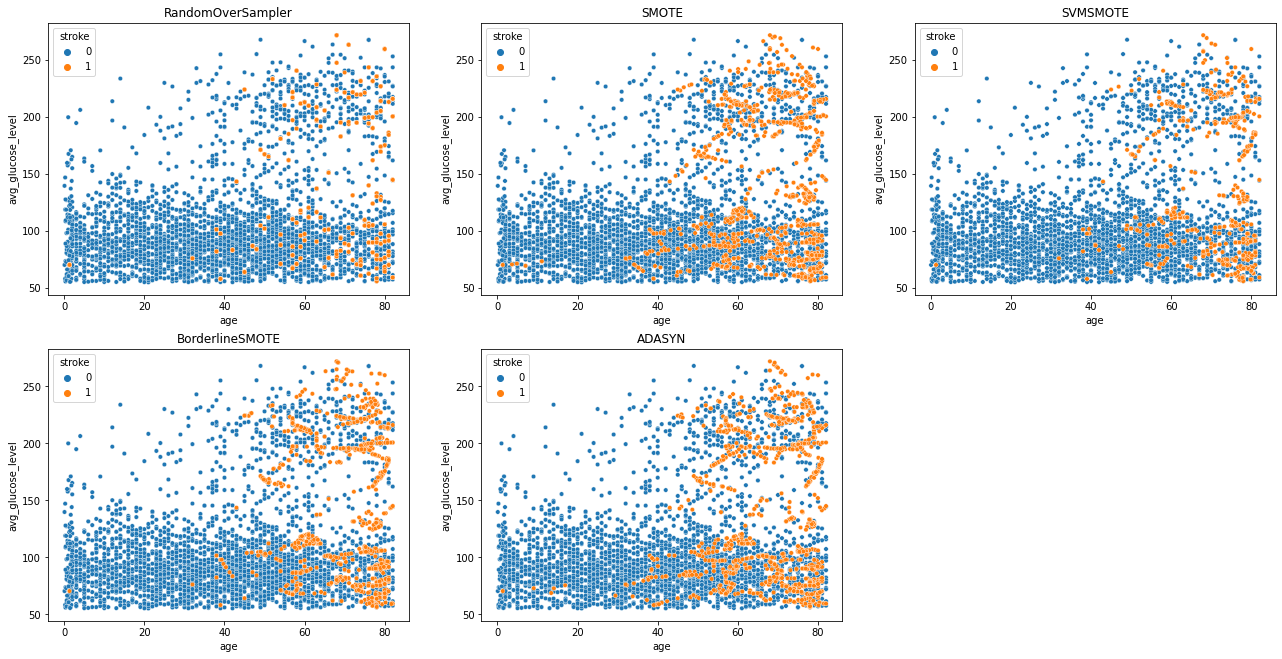

In [17]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

models = [Pipeline([('Trans', transformer),
                  ('RandomOverSampler', RandomOverSampler(sampling_strategy=0.3, random_state=1))]),
          Pipeline([('Trans', transformer),
                  ('SMOTE', SMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('SVMSMOTE', SVMSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('BorderlineSMOTE', BorderlineSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('ADASYN', ADASYN(sampling_strategy=0.3))])
          ]

pyplot.figure(figsize=(22, 11))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(2, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig('oversampling.png')
pyplot.show()

Test different ratios for each oversampling technique.

Run the code block below

Without Oversampling: 0.149213
RandomOverSampler (ratio:0.1): 0.154357
RandomOverSampler (ratio:0.2): 0.149907
RandomOverSampler (ratio:0.3): 0.147290
RandomOverSampler (ratio:0.4): 0.135656
RandomOverSampler (ratio:0.5): 0.137938
RandomOverSampler (ratio:0.6): 0.139560
RandomOverSampler (ratio:0.7): 0.130670
RandomOverSampler (ratio:0.8): 0.136591
RandomOverSampler (ratio:0.9): 0.124058
Without Oversampling: 0.149213
SMOTE (ratio:0.1): 0.160995
SMOTE (ratio:0.2): 0.158136
SMOTE (ratio:0.3): 0.139896
SMOTE (ratio:0.4): 0.147223
SMOTE (ratio:0.5): 0.136958
SMOTE (ratio:0.6): 0.138350
SMOTE (ratio:0.7): 0.139826
SMOTE (ratio:0.8): 0.147573
SMOTE (ratio:0.9): 0.143384
Without Oversampling: 0.149213
SVMSMOTE (ratio:0.1): 0.155112
SVMSMOTE (ratio:0.2): 0.147738
SVMSMOTE (ratio:0.3): 0.173206
SVMSMOTE (ratio:0.4): 0.149144
SVMSMOTE (ratio:0.5): 0.157157
SVMSMOTE (ratio:0.6): 0.159101
SVMSMOTE (ratio:0.7): 0.163459
SVMSMOTE (ratio:0.8): 0.155951
SVMSMOTE (ratio:0.9): 0.166084
Without Oversamp

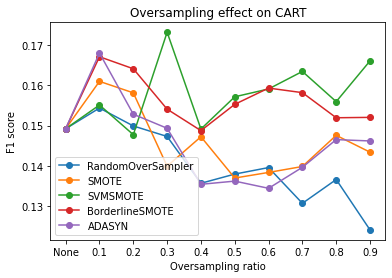

In [10]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

ratios = np.arange(0.1, 1, 0.1)
names = ['None'] + [str(round(ratio, 1)) for ratio in ratios]

naive_model = Pipeline([step_trans,
                  step_cart])

models = [
    Pipeline([step_trans,
                      ('RandomOverSampler', RandomOverSampler(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('SMOTE', SMOTE(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('SVMSMOTE', SVMSMOTE(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('BorderlineSMOTE', BorderlineSMOTE(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('ADASYN', ADASYN(random_state=seed)),
                      step_cart]),
          ]

for model in models:

    cv_results = cross_val_score(naive_model, X_train, Y_train, cv=kfold, scoring=scoring)
    results = [cv_results.mean()]
    print("Without Oversampling: %f" % (cv_results.mean()))

    for ratio in ratios:
        model.steps[1][1].set_params(sampling_strategy=ratio)
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append(cv_results.mean())
        print("%s (ratio:%.1f): %f" % (model.steps[1][0], ratio, cv_results.mean()))

    line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
    pyplot.legend()
    pyplot.ylabel('F1 score')
    pyplot.xlabel('Oversampling ratio')

pyplot.title("Oversampling effect on CART")
pyplot.savefig('CART_oversampling.png')
pyplot.show()


In general, oversampling does not show stability and significant improvemenct in the performance of model

## 4.4 Undersampling's effect on CART model's performance

View how different undersampling techniques changes our class distribution.

Run the code block below

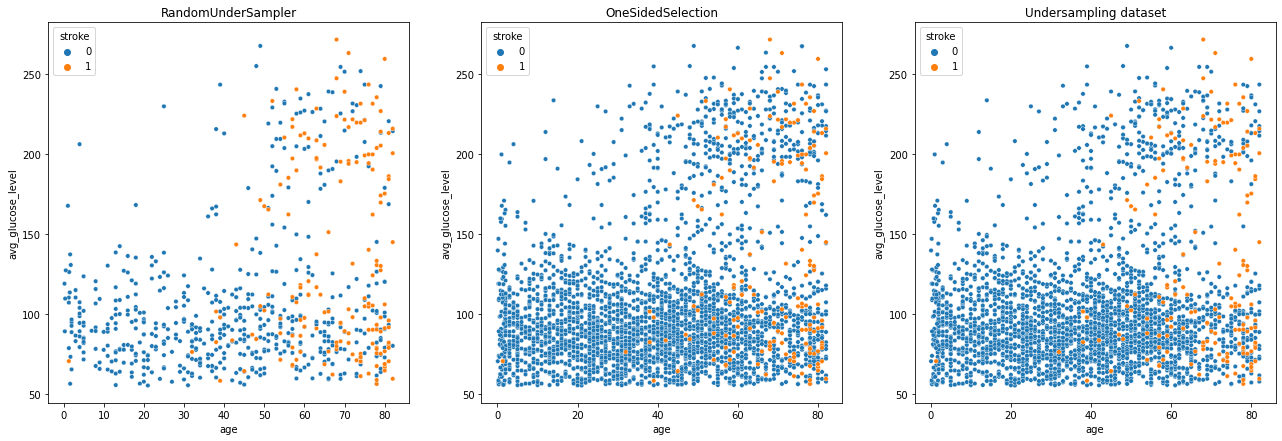

In [36]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))

models = [
          Pipeline([step_trans,
                  ('RandomUnderSampler', RandomUnderSampler(sampling_strategy=0.3))]),
          Pipeline([step_trans,
                  ('OneSidedSelection', OneSidedSelection())]),
          Pipeline([step_trans,
                  ('NeighbourhoodCleaningRule', NeighbourhoodCleaningRule())])
          ]

pyplot.figure(figsize=(22, 7))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("undersampling.png")
pyplot.show()

Test the impact of different undersampling technique on the CART's performance.

Note that:
* with Random undersampling: we test different ratios.
* with One-side Selection and Neighbourhood Cleaning Rule: we test only one and duplicate the result to draw a line graph.

Run the code block below

Without undersampling: 0.142887
RandomUnderSampler(ratio:0.1): 0.163142
RandomUnderSampler(ratio:0.2): 0.174084
RandomUnderSampler(ratio:0.3): 0.181655
RandomUnderSampler(ratio:0.4): 0.178157
RandomUnderSampler(ratio:0.5): 0.172338
RandomUnderSampler(ratio:0.6): 0.168584
RandomUnderSampler(ratio:0.7): 0.166503
RandomUnderSampler(ratio:0.8): 0.166236
RandomUnderSampler(ratio:0.9): 0.162875
Without undersampling: 0.142887
OneSidedSelection: 0.144605
Without undersampling: 0.142887
NeighbourhoodCleaningRule: 0.178109


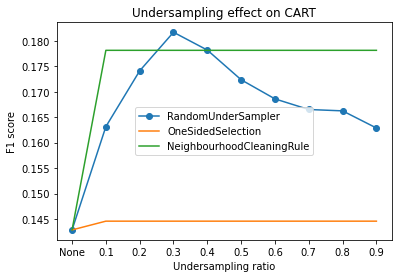

In [11]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))


ratios = np.arange(0.1, 0.91, 0.1)
names = ['None'] + [str(round(ratio, 1)) for ratio in ratios]


models = [Pipeline([step_trans,
                      ('RandomUnderSampler', RandomUnderSampler(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('OneSidedSelection', OneSidedSelection(random_state=seed)),
                      step_cart]),
          Pipeline([step_trans,
                      ('NeighbourhoodCleaningRule', NeighbourhoodCleaningRule()),
                      step_cart])
          ]

naive_model = Pipeline([step_trans,
                  step_cart])

for i in range(len(models)):

    cv_results = cross_val_score(naive_model, X_train, Y_train, cv=kfold, scoring=scoring)
    results = [cv_results.mean()]
    print("Without undersampling: %f" % (cv_results.mean()))

    if i == 0:
        for ratio in ratios:
            models[0].steps[1][1].set_params(sampling_strategy=ratio)
            cv_results = cross_val_score(models[0], X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results.mean())
            print("%s(ratio:%.1f): %f" % (models[0].steps[1][0], ratio, cv_results.mean()))
        line = pyplot.plot(names, results, '-o', label=models[i].steps[1][0])
    else:
        cv_results = cross_val_score(models[i], X_train, Y_train, cv=kfold, scoring=scoring)
        results.extend([cv_results.mean()] * (len(ratios)))
        print("%s: %f" % (models[i].steps[1][0], cv_results.mean()))
        line = pyplot.plot(names, results, '-', label=models[i].steps[1][0])

    pyplot.legend()
    pyplot.ylabel('F1 score')
    pyplot.xlabel('Undersampling ratio')

pyplot.title("Undersampling effect on CART")
pyplot.savefig('CART_undersampling.png')
pyplot.show()

Random undersampling with ratio 3:10 and Neighbor Cleaning Rule seem to be the most optimistic.

## 4.5 Combine Oversampling and UnderSampling

Because SMOTE, Random undersampling, Neighbourhood Cleaning Rule show a lift in the performance, it's desirable to test their combination.

Run the code block below to combine SMOTE and Neighbourhood Cleaning Rule

SVMSMOTE(ratio:0.06): 0.174852
SVMSMOTE(ratio:0.16): 0.173485
SVMSMOTE(ratio:0.26): 0.173994
SVMSMOTE(ratio:0.36): 0.175560
SVMSMOTE(ratio:0.46): 0.178632
SVMSMOTE(ratio:0.56): 0.183948
SVMSMOTE(ratio:0.66): 0.182210


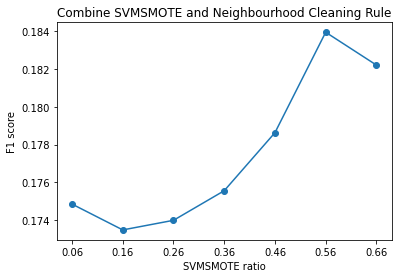

In [12]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))


ratios = np.arange(0.06, 0.7, 0.1)
results = []
names = [str(round(k, 2)) for k in ratios]

model = Pipeline([step_trans,
                  ('SVMSMOTE', SVMSMOTE(random_state=seed)),
                  ('NeighbourhoodCleaningRule', NeighbourhoodCleaningRule()),
                  step_cart])

for ratio in ratios:
    model['SVMSMOTE'].set_params(sampling_strategy=ratio)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results.mean())
    print("SVMSMOTE(ratio:%.2f): %f" % (ratio, cv_results.mean()))

line = pyplot.plot(names, results, '-o')
pyplot.ylabel('F1 score')
pyplot.xlabel('SVMSMOTE ratio')
pyplot.title("Combine SVMSMOTE and Neighbourhood Cleaning Rule")
pyplot.savefig("CART_smote_ncr.png")
pyplot.show()

Run the code block below to combine SMOTE and Random undersampling

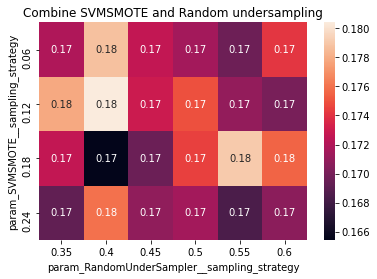

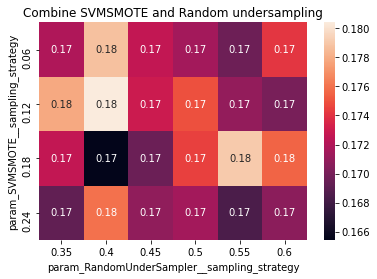

In [14]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

oversampling_strategies = [0.06, 0.12, 0.18, 0.24]
undersampling_strategies = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

param_grid = dict(SVMSMOTE__sampling_strategy=oversampling_strategies, RandomUnderSampler__sampling_strategy=undersampling_strategies)
model = Pipeline([step_trans,
                  ('SVMSMOTE', SVMSMOTE(random_state=seed)),
                  ('RandomUnderSampler', RandomUnderSampler(random_state=seed)),
                  step_cart])

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid.fit(X_train, Y_train)

pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
    values='mean_test_score', columns='param_RandomUnderSampler__sampling_strategy', index ='param_SVMSMOTE__sampling_strategy')


seaborn.heatmap(pvt, annot=True)
pyplot.title("Combine SVMSMOTE and Random undersampling")
title = 'CART_smote_randomundersampling'
pyplot.savefig(title + '.png')
pyplot.show()

## 4.6 SMOTE + Tomek Links and SMOTE + Edited Nearest Neighbour

After consulting from various article, we'll test another 2 combinations of oversampling and undersampling technique.

Run the code block below to see how `SMOTETomek` and `SMOTEENN` change class distribution.

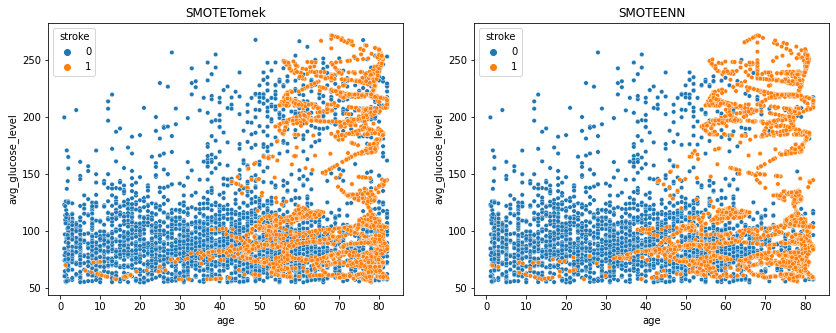

In [13]:

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

models = [Pipeline([step_trans,
                  ('SMOTETomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')))]),
          Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')))])
          ]

pyplot.figure(figsize=(14, 5))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 2, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("standard_combine.png")
pyplot.show()

View the effect of `SMOTETomek` and `SMOTEENN` on CART's performance.

Run the code block below

CART: 0.142887 (0.055548)
SMOTETomek: 0.133969 (0.050675)
SMOTEENN: 0.173533 (0.039070)


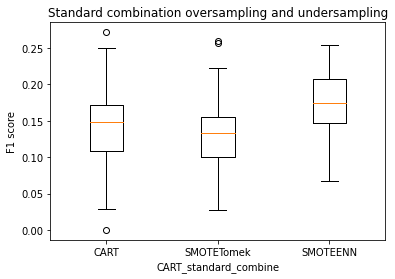

In [15]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []

models = [Pipeline([step_trans,
                  step_cart]),
          Pipeline([step_trans,
                  ('SMOTETomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                  step_cart]),
          Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                  step_cart])
          ]

for model in models:

    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(model.steps[1][0])
    print("%s: %f (%f)" % (model.steps[1][0], cv_results.mean(), cv_results.std()))

my_boxplot(data=results, labels=names, xlabel='CART_standard_combine', ylabel='F1 score', title='Standard combination oversampling and undersampling')

It's notable that `SMOTEENN` show a significant lift in the performance. We'll dig deeper to it by test it with different ratios.

Without sampling: 0.142887
SMOTEENN (ratio:0.1): 0.188230
SMOTEENN (ratio:0.2): 0.178020
SMOTEENN (ratio:0.3): 0.184862
SMOTEENN (ratio:0.4): 0.185716
SMOTEENN (ratio:0.5): 0.187097
SMOTEENN (ratio:0.6): 0.184916
SMOTEENN (ratio:0.7): 0.194934
SMOTEENN (ratio:0.8): 0.180496
SMOTEENN (ratio:0.9): 0.184903


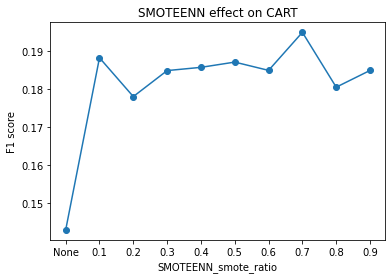

In [16]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

ratios = np.arange(0.1, 0.91, 0.1)
names = ['None'] + [str(round(ratio, 1)) for ratio in ratios]

naive_model = Pipeline([step_trans,
                        step_cart])

model = Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))),
                  step_cart])

cv_results = cross_val_score(naive_model, X_train, Y_train, cv=kfold, scoring=scoring)
results = [cv_results.mean()]
print("Without sampling: %f" % (cv_results.mean()))

for ratio in ratios:
    model['SMOTEENN'].set_params(smote=SMOTE(sampling_strategy=ratio, random_state=seed))
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results.mean())
    print("SMOTEENN (ratio:%.1f): %f" % (ratio, cv_results.mean()))

line = pyplot.plot(names, results, '-o', label=model.steps[1][0])
pyplot.ylabel('F1 score')
pyplot.xlabel('SMOTEENN_smote_ratio')

pyplot.title("SMOTEENN effect on CART")
pyplot.savefig('CART_smotenn.png')
pyplot.show()

## 4.7 Class-weighed Decision Tree

After consulting in several article, we feel tempted to test trying cost-sensitive decision tree. Though this is a large subfield of machine learning. In our project, we carry out this by tuning `class_weight` in Scikit-learn `DecisionTreeClassifier`.

Run the code block below

Class_weight 1: 0.142887
Class_weight 3: 0.140891
Class_weight 5: 0.112422
Class_weight 7: 0.116300
Class_weight 9: 0.114232
Class_weight 11: 0.101077
Class_weight 13: 0.114506
Class_weight 15: 0.118184
Class_weight 17: 0.114705
Class_weight 19: 0.114739
Class_weight 21: 0.117988
Class_weight 23: 0.124408


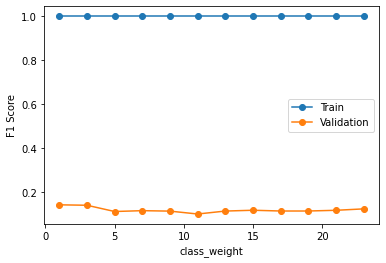

In [17]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                     step_cart])
train_results = []
validation_results = []
ratios = [k for k in range(1, 25, 2)]
class_weights = [{0: 1, 1: k} for k in ratios]

for class_weight in class_weights:
    model['CART'].set_params(class_weight=class_weight)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())
    print("Class_weight %d: %f" % (class_weight[1], cv_results['test_score'].mean()))

my_lineplot(x=ratios, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='class_weight', ylabel='F1 Score', title='CART_class_weight')

Contrary to our expectation, there's no improvement. I'm so confused, can you explain for me?

After doing many experment, we note that class distribution should be keep 3:10 - 4:10 for our CART model.
In the future, we'll use `SMOTEENN` with sampling strategy be 0.4


## 4.8 Different encoding strategies' effect on CART model's performance

In our project, there's not ordinal variable. We'll test which kind of encoding is better for our specific problem.

Run the code block below

Ordinal: 0.185716
... with: n_leaves: 227 	depth: 18
OneHot: 0.196660
... with: n_leaves: 223 	depth: 18


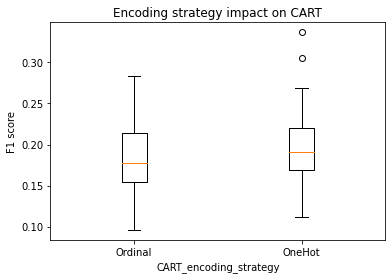

In [18]:
transformers = [('Ordinal', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                               ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                              remainder='passthrough')),
                ('OneHot', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                              ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                             remainder='passthrough'))
                ]

step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []
models = []

for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      step_smote,
                      step_cart])
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))

    model.fit(X_train, Y_train)
    models.append(model)

    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))
    # tree.plot_tree(model['CART'])
    # pyplot.show()

my_boxplot(xlabel='CART_encoding_strategy', data=results, labels=names, ylabel="F1 score", title="Encoding strategy impact on CART")

According to some articles, Onehot encoding is generally more suitable for norminal variables and in Decision Tree model, Ordinal encoding is more suitable.

In our problem, after doing many experiment, we do not any significant different.

## 4.9) Discretization's effect on CART's performance

Decision Tree prefers categorical variables. So, it's desirable to transform numerical variables to have discrete probability distribution where each value is assigned a label and have an ordinal relationship

Run the code block below

4Bins: 0.151118
... with: n_leaves: 297 	depth: 20


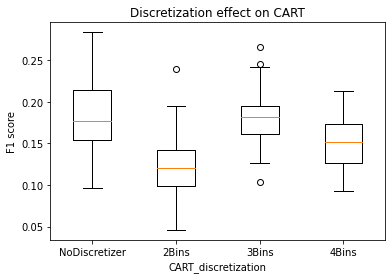

NoDiscretizer: 0.196660
... with: n_leaves: 223 	depth: 18
2Bins: 0.124584
... with: n_leaves: 271 	depth: 17
3Bins: 0.171845
... with: n_leaves: 306 	depth: 18
4Bins: 0.145225
... with: n_leaves: 328 	depth: 18


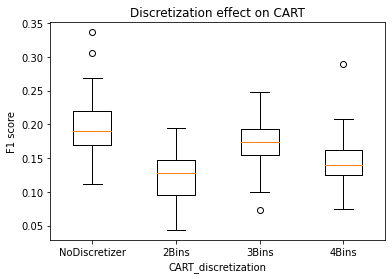

In [22]:
transformers = [('NoDiscretizer', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                                               ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                              remainder='passthrough')),
                ('2Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('3Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough')),
                ('4Bins', ColumnTransformer([('NumTrans', Pipeline([('SimpleImputer', SimpleImputer()), ('KBinsDiscretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'))]), numerical_ix),
                                                        ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                                       remainder='passthrough'))
                ]

step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

results = []
names = []
for name, transformer in transformers:
    model = Pipeline([('Trans', transformer),
                      step_smote,
                      step_cart])
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    print("%s: %f" % (name, cv_results.mean()))

    model.fit(X_train, Y_train)

    print("... with: n_leaves: %d \tdepth: %d" % (model['CART'].get_n_leaves(), model['CART'].get_depth()))

my_boxplot(xlabel='CART_discretization', data=results, labels=names, ylabel="F1 score", title="Discretization effect on CART")

Discretization seems to degrade the performance of the model. Why? I don't know, do you know? :)

## 4.10 Algorithm Tuning

```
DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
```

#### `splitter`

According to some articles, decision trees tend to overfit on data with large number of features.

Besides, it can do feature selection automatically by applying (Im)purity measure. This can be done by set parameter `splitter=best`. Another value for `splitter` is `random`. If we have hundreds of features, `best` is more preferred because `random` might result in features that don’t give much information, which would lead to a more deeper, less precise tree.

However, with our Stroke data is small with 10 features, so we might be able to see the difference.

Run the code block below

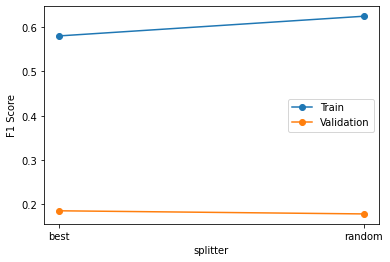

In [20]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
splitters = ['best', 'random']

for splitter in splitters:
    model['CART'].set_params(splitter=splitter)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=splitters, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='splitter', ylabel='F1 Score', title='CART_tune_splitter')

#### `max_depth`

This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. However, `max_depth` needs controlling to prevent overfitting.

Run the code block below

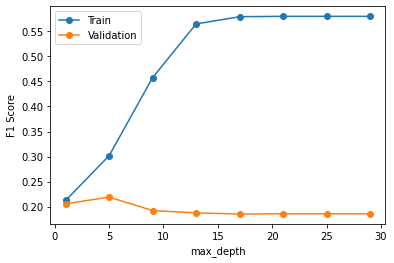

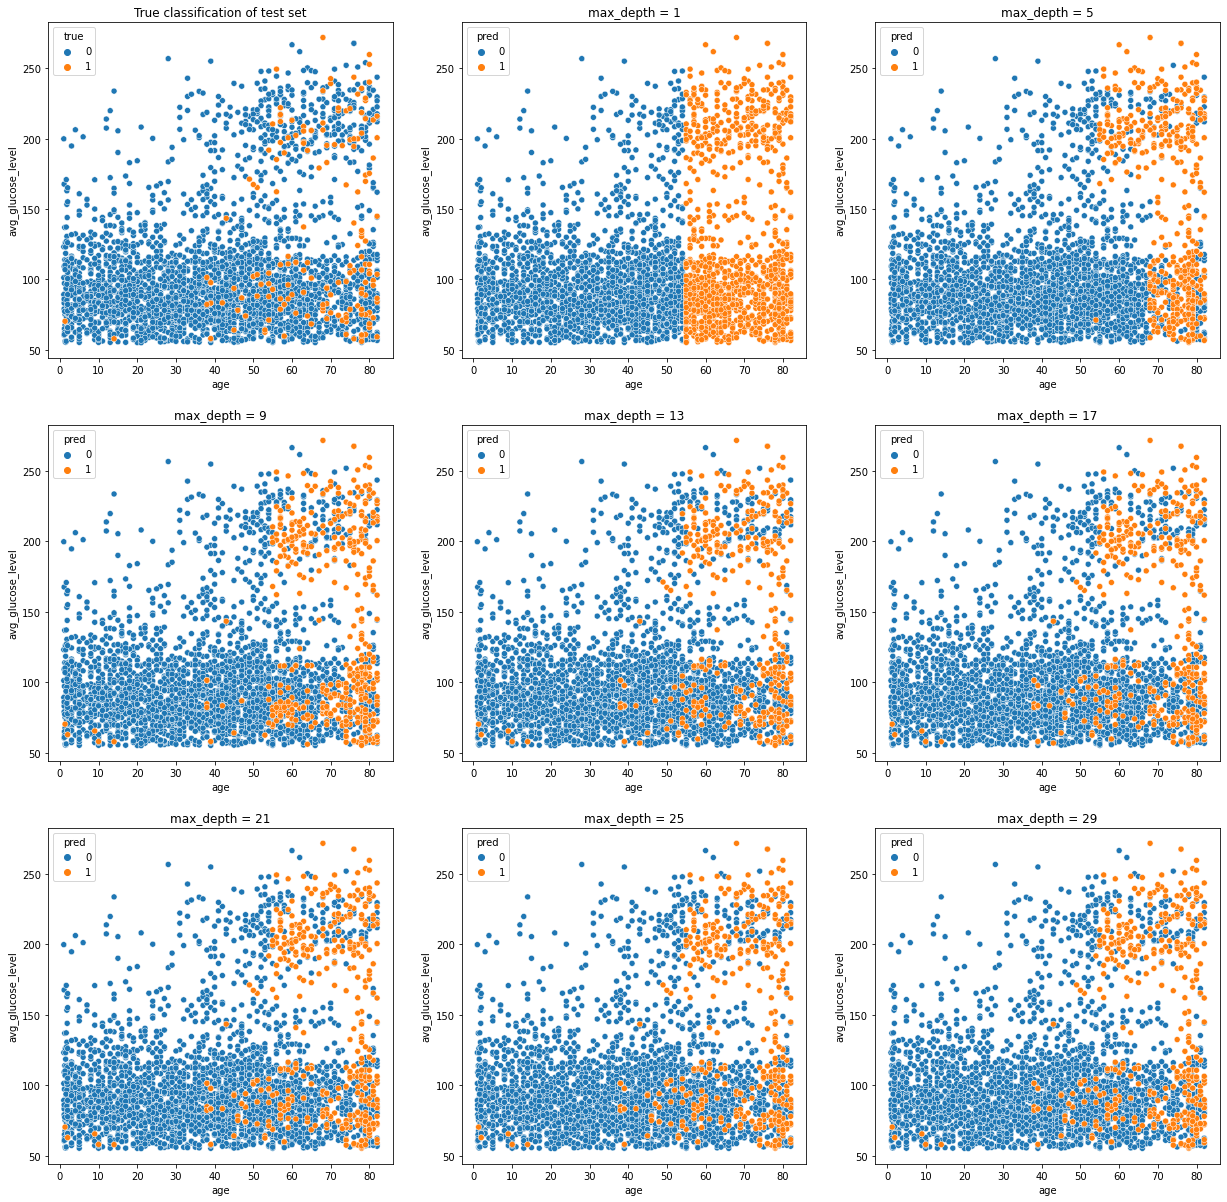

In [30]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
max_depths = np.arange(1, 31, 4)

for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_depths, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_depth', ylabel='F1 Score', title='CART_tune_maxdepth')



data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test set')

i = 2
for max_depth in max_depths:
    model['CART'].set_params(max_depth=max_depth)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('max_depth = ' + str(max_depth))
    i += 1

pyplot.savefig('CART_maxdepth.png')
pyplot.show()

As we can see in the figure, the model predicts fairly well on train set as `max_depth` increases, but fails on new data.


#### `min_samples_split`

The minimum number of samples required to split an internal node. When we increase `min_samples_split`, tree becomes more constrained because it have to consider more examples.

Run the code block below

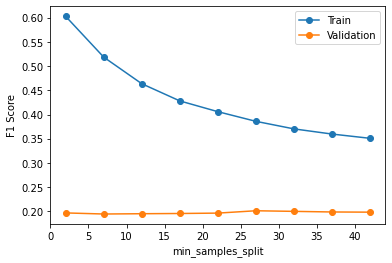

In [23]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
min_samples_splits = np.arange(2, 43, 5)

for min_samples_split in min_samples_splits:
    model['CART'].set_params(min_samples_split=min_samples_split)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_splits, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_split', ylabel='F1 Score', title='CART_tune_minsamplessplit')

#### `min_samples_leaf`

The minimum number of samples required to be at a leaf node. At any depth, regardless of `min_samples_split`, a split point is only be accepted if each of its leaves have at least `min_samples_leaf` samples.

Run the code block below

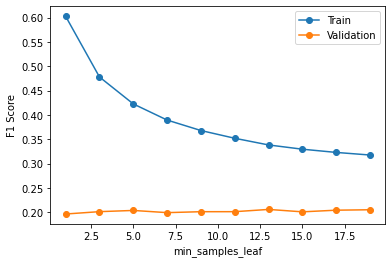

In [24]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
min_samples_leafs = np.arange(1, 21, 2)

for min_samples_leaf in min_samples_leafs:
    model['CART'].set_params(min_samples_leaf=min_samples_leaf)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=min_samples_leafs, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='min_samples_leaf', ylabel='F1 Score', title='CART_tune_minleafsplit')

#### `max_features`

It represents the maximum number of features to consider when looking for the best split.

Run the code block below

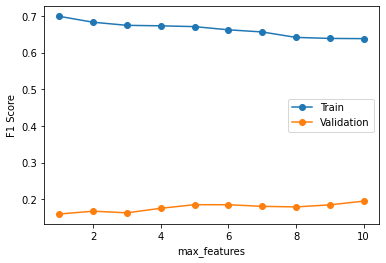

In [25]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
max_featuress = np.arange(1, 11, 1)

for max_features in max_featuress:
    model['CART'].set_params(max_features=max_features)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=max_featuress, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='max_features', ylabel='F1 Score', title='CART_tune_maxfeatures')

#### `ccp_alpha`

All the tuning steps done above is refered to as pre-pruning. In this part we'll do post-pruning by controlling the cost complexity pruning.

Let's view the appropriate values for `ccp_alpha` for tuning.

Run the code block below

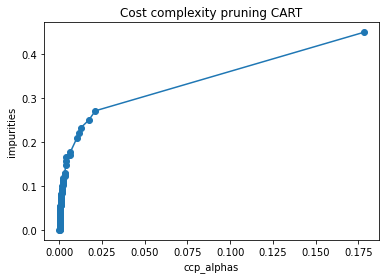

In [26]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))

pipeline = Pipeline([step_trans,
                     step_smote
                    ])
model = DecisionTreeClassifier(random_state=seed)

X_new, Y_new = pipeline.fit_resample(X_train, Y_train)

path = model.cost_complexity_pruning_path(X_new, Y_new)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

line = pyplot.plot(ccp_alphas, impurities, '-o')
pyplot.ylabel('impurities')
pyplot.xlabel('ccp_alphas')

pyplot.title("Cost complexity pruning CART")
pyplot.savefig('CART_cost_complexity_pruning.png')
pyplot.show()

Now, we'll tune this parameter.

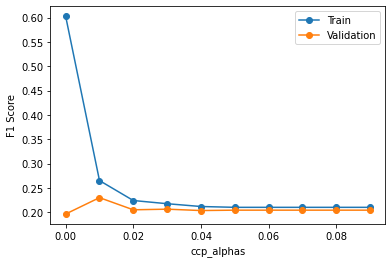

In [35]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

train_results = []
validation_results = []
ccp_alphas = np.arange(0, 0.1, 0.01)

for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)

    cv_results = cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)
    train_results.append(cv_results['train_score'].mean())
    validation_results.append(cv_results['test_score'].mean())

my_lineplot(x=ccp_alphas, y1=train_results, y2=validation_results, label1='Train', label2='Validation', xlabel='ccp_alphas', ylabel='F1 Score', title='CART_tune_ccpalpha')

Looking at the figure above, we're something to happy about the lift in the evaluation of the validation set with `ccp_alpha` >= 0.01

However, I'm so lucky to do another crazy experiment below.

Pleaseeee run the code block below

ccp_alpha (0.001): 0.381481
ccp_alpha (0.002): 0.313480
ccp_alpha (0.003): 0.313433
ccp_alpha (0.004): 0.299435
ccp_alpha (0.005): 0.287653
ccp_alpha (0.006): 0.287653
ccp_alpha (0.007): 0.287653
ccp_alpha (0.008): 0.287653


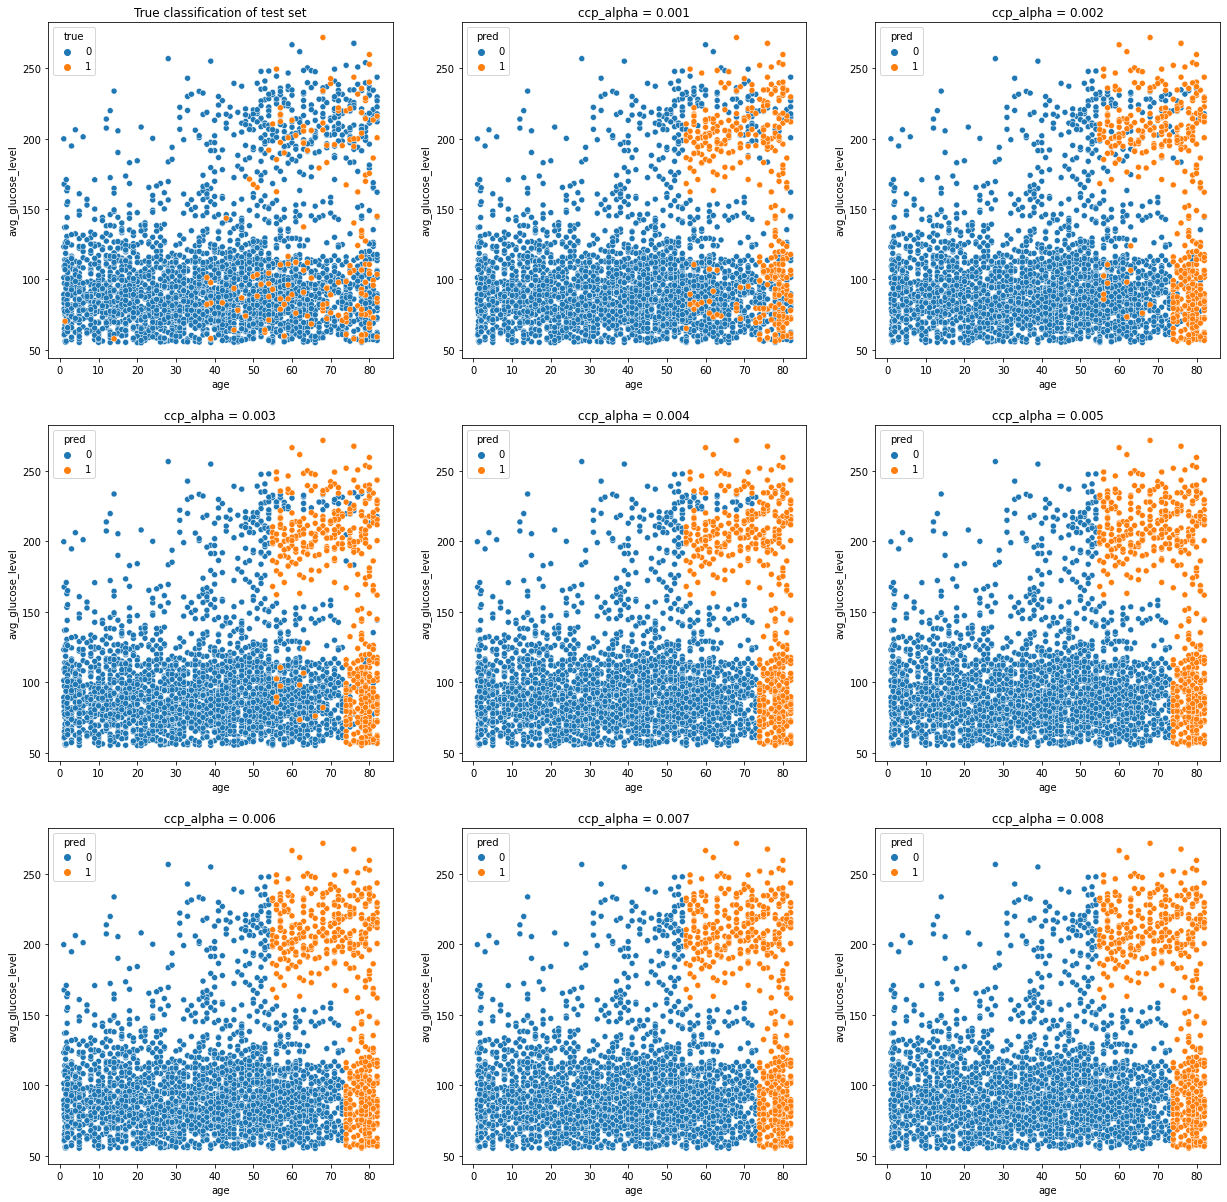

In [36]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed))

model = Pipeline([step_trans,
                  step_smote,
                  step_cart])

ccp_alphas = np.arange(0.001, 0.009, 0.001)

data_train = X_train.copy()
data_train['true'] = Y_train
data_train.sort_values('true', inplace=True)

pyplot.figure(figsize=(21, 21))
pyplot.subplot(3, 3, 1)
seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test set')

i = 2
for ccp_alpha in ccp_alphas:
    model['CART'].set_params(ccp_alpha=ccp_alpha)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_train)
    print("ccp_alpha (%.3f): %f" % (ccp_alpha, f1_score(Y_train, Y_pred)))

    data_train = X_train.copy()

    data_train['pred'] = Y_pred
    data_train.sort_values('pred', inplace=True)
    pyplot.subplot(3, 3, i)
    seaborn.scatterplot(data=data_train, x='age', y='avg_glucose_level', hue='pred')
    pyplot.title('ccp_alpha = ' + str(ccp_alpha))
    i += 1

pyplot.savefig('CART_ccpalpha.png')
pyplot.show()

Though the performance lifts significantly, the figure above suggests a cautious if we rely on the model. Almost all instances in the right hand is misclassified, which is probably not real.

# 6. Finalizing

## 6.1 Predictions on test set

Base on these above experiments, we'll finalize our CART model as below.

[[1437  152]
 [  45   37]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1589
           1       0.20      0.45      0.27        82

    accuracy                           0.88      1671
   macro avg       0.58      0.68      0.60      1671
weighted avg       0.93      0.88      0.90      1671



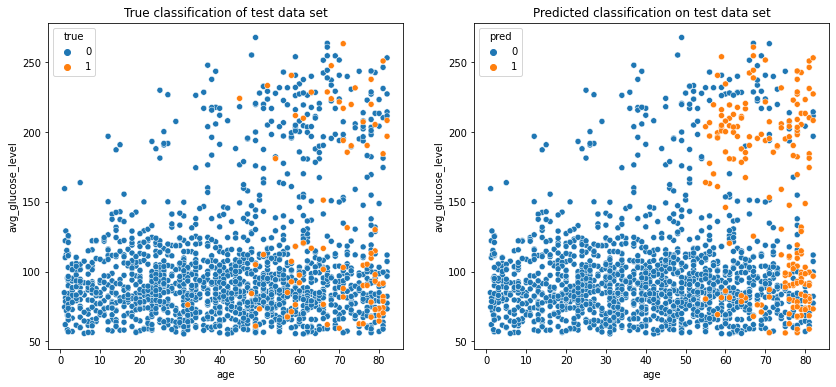

In [40]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OneHotEncoder', OneHotEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_smote = ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'),
                                   smote=SMOTE(sampling_strategy=0.4, random_state=seed)))
step_cart = ('CART', DecisionTreeClassifier(random_state=seed, ccp_alpha=0.001))

cart = Pipeline([step_trans,
                  step_smote,
                  step_cart])

# prepare the model
cart.fit(X_train, Y_train)

# estimate on the test dataset
Y_pred = cart.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

data_test = X_test.copy()
data_test['true'] = Y_test
data_test['pred'] = Y_pred
data_test.sort_values('true', inplace=True)

pyplot.figure(figsize=(14, 6))
pyplot.subplot(1, 2, 1)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='true')
pyplot.title('True classification of test data set')

data_test.sort_values('pred', inplace=True)
pyplot.subplot(1, 2, 2)
seaborn.scatterplot(data=data_test, x='age', y='avg_glucose_level', hue='pred')
pyplot.title('Predicted classification on test data set')
title = "CART_final_prediction"
pyplot.savefig(title + '.png')
pyplot.show()


We expect recall is as high as possible, because we don't want to mis-label any stroke patients as not stroke when we do prediction.

## 6.2 Save model for later use

Save model

In [38]:
dump(cart, open('cart.pkl', 'wb'))

Load saved model

In [ ]:
model = load(open('cart.pkl', 'rb'))

## 6.3 Visualize prediction results

ValueError: 'c' argument has 961 elements, which is inconsistent with 'x' and 'y' with size 1589.

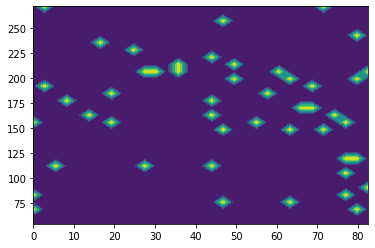

In [53]:
xx, yy = np.meshgrid(np.arange(X_test['age'].min() - 1, X_test['age'].max() + 1, 2.75),
                     np.arange(X_test['avg_glucose_level'].min() - 1, X_test['avg_glucose_level'].max() + 1, 7.25))
z = Y_test.values[:(yy.shape[0]*yy.shape[1])].reshape(yy.shape)
s = pyplot.contourf(xx, yy, z)

for i, color in zip(range(2), "by"):
        idx = np.where(Y_test.values == i)
        pyplot.scatter(X_test.values[idx, 0], X_test.values[idx, 1], c=Y_test.values[:(yy.shape[0]*yy.shape[1])],
                    edgecolor='k', s=20)

pyplot.xlabel('age')
pyplot.ylabel('avg_glucose_level')
pyplot.savefig("CART_boundary.png")
pyplot.show()

In [36]:
X_test['avg_glucose_level'].min() -1

54.22